In [1]:
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import numpy as np
from shapely import Polygon as polygon
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
ucrb_boundary = gpd.read_file('../multisite/polygons/Upper_Colorado_River_Basin_Boundary.json')
g = [i for i in ucrb_boundary.geometry]
x,y = g[0].exterior.coords.xy
all_coords = np.dstack((x,y))
x = all_coords[0][:,0]+360
ucrb_boundary = gpd.GeoSeries(polygon(list(zip(x,y))),crs=4326)
# ucrb_boundary = ucrb_boundary.set_crs()

hcdn_boundaries = gpd.read_file('./ucrb_hcdn_co_polygons_final.json')
bound_list = []
for geom in hcdn_boundaries.geometry:
    x,y = geom.exterior.coords.xy
    all_coords = np.dstack((x,y))
    x = all_coords[0][:,0]+360
    bound_list.append(polygon(list(zip(x,y))))


hcdn_boundaries = gpd.GeoSeries(bound_list, crs=4326)

lower_basin_bounds = gpd.GeoSeries(polygon([(-115.7061+360, 29.83855), 
                                            (-115.7061+360, 39.30284),
                                            (-107.78314+360, 39.30284),
                                            (-107.78314+360, 29.83855),
                                            (-115.7061+360, 29.83855)]), crs=4326)

west_wide_bounds = gpd.GeoSeries(polygon([(-122+360, 29), 
                                            (-122+360, 50),
                                            (-100+360, 350),
                                            (-100+360, 29),
                                            (-122+360, 29)]), crs=4326)

In [3]:
grace_corrected_ds = rxr.open_rasterio('../../data/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc')[1]
grace_corrected_ds = grace_corrected_ds.rio.write_crs(4326)
grace_corrected_clipped_ds = grace_corrected_ds.rio.clip(ucrb_boundary.geometry)
grace_corrected_clipped_ds['lwe_thickness'].attrs['units'] = 'cm'
grace_corrected_filtered_ds = grace_corrected_clipped_ds.where(grace_corrected_clipped_ds['lwe_thickness']!=9.96921e+36)
grace_corrected_filtered_ds['time'] = [datetime(2002,1,1,0,0)+timedelta(days=delta) for delta in grace_corrected_filtered_ds.time.values]
grace_corrected_filtered_ds['WY'] = grace_corrected_filtered_ds.time.dt.year.where(grace_corrected_filtered_ds.time.dt.month<10,grace_corrected_filtered_ds.time.dt.year+1)

grace_corrected_clipped_ds_hcdn = grace_corrected_ds.rio.clip(hcdn_boundaries.geometry)
grace_corrected_clipped_ds_hcdn['lwe_thickness'].attrs['units'] = 'cm'
grace_corrected_filtered_ds_hcdn = grace_corrected_clipped_ds_hcdn.where(grace_corrected_clipped_ds_hcdn['lwe_thickness']!=9.96921e+36)
grace_corrected_filtered_ds_hcdn['time'] = [datetime(2002,1,1,0,0)+timedelta(days=delta) for delta in grace_corrected_filtered_ds_hcdn.time.values]
grace_corrected_filtered_ds_hcdn['WY'] = grace_corrected_filtered_ds_hcdn.time.dt.year.where(grace_corrected_filtered_ds_hcdn.time.dt.month<10,grace_corrected_filtered_ds_hcdn.time.dt.year+1)

grace_corrected_clipped_ds_lower = grace_corrected_ds.rio.clip(lower_basin_bounds)
grace_corrected_clipped_ds_lower ['lwe_thickness'].attrs['units'] = 'cm'
grace_corrected_filtered_ds_lower  = grace_corrected_clipped_ds_lower.where(grace_corrected_clipped_ds_lower['lwe_thickness']!=9.96921e+36)
grace_corrected_filtered_ds_lower['time'] = [datetime(2002,1,1,0,0)+timedelta(days=delta) for delta in grace_corrected_filtered_ds_lower.time.values]
grace_corrected_filtered_ds_lower['WY'] = grace_corrected_filtered_ds_lower.time.dt.year.where(grace_corrected_filtered_ds_lower.time.dt.month<10,grace_corrected_filtered_ds_lower.time.dt.year+1)

grace_corrected_clipped_ds_west = grace_corrected_ds.rio.clip(west_wide_bounds)
grace_corrected_clipped_ds_west ['lwe_thickness'].attrs['units'] = 'cm'
grace_corrected_filtered_ds_west  = grace_corrected_clipped_ds_west.where(grace_corrected_clipped_ds_west['lwe_thickness']!=9.96921e+36)
grace_corrected_filtered_ds_west['time'] = [datetime(2002,1,1,0,0)+timedelta(days=delta) for delta in grace_corrected_filtered_ds_west.time.values]
grace_corrected_filtered_ds_west['WY'] = grace_corrected_filtered_ds_west.time.dt.year.where(grace_corrected_filtered_ds_west.time.dt.month<10,grace_corrected_filtered_ds_west.time.dt.year+1)

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\rioxarray\_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


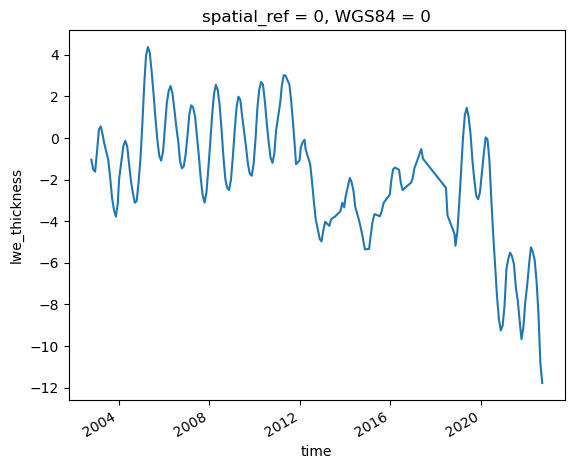

In [51]:
grace_corrected_filtered_ds.mean(dim=['x','y'])['lwe_thickness'].rolling(time=8, center=True).mean().dropna("time").plot()

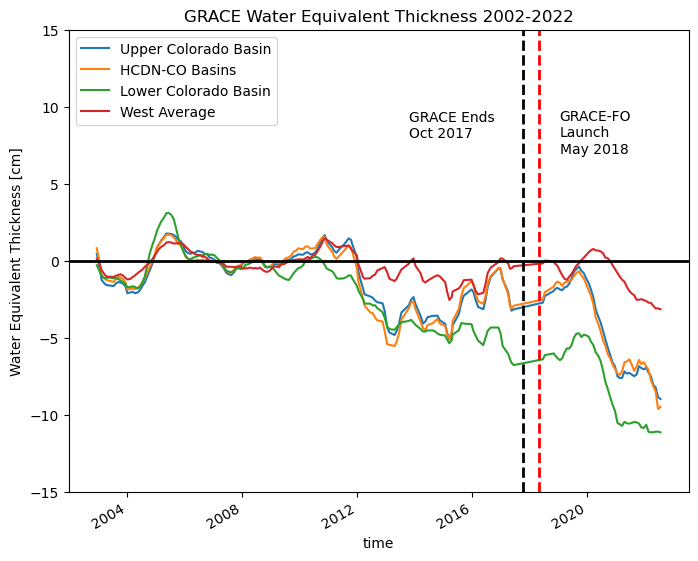

In [6]:
# Using 4 month rolling average to smooth the data a bit, same signals as the raw output
fig,ax=plt.subplots(figsize=(8,6))
grace_corrected_filtered_ds.mean(dim=['x','y'])['lwe_thickness'].rolling(time=12, center=True).mean().dropna("time").plot(ax=ax, label='Upper Colorado Basin')
grace_corrected_filtered_ds_hcdn.mean(dim=['x','y'])['lwe_thickness'].rolling(time=12, center=True).mean().dropna("time").plot(ax=ax, label='HCDN-CO Basins')
grace_corrected_filtered_ds_lower.mean(dim=['x','y'])['lwe_thickness'].rolling(time=12, center=True).mean().dropna("time").plot(ax=ax, label='Lower Colorado Basin')
grace_corrected_filtered_ds_west.mean(dim=['x','y'])['lwe_thickness'].rolling(time=12, center=True).mean().dropna("time").plot(ax=ax, label='West Average')
ax.legend()
ax.axvline(dt.date(2017,10,1), color='k', lw=2, ls='--')
ax.axvline(dt.date(2018,5,1), color='r', lw=2, ls='--')
ax.text(x=dt.date(2013,10,15),y=8,s='GRACE Ends\nOct 2017',)
ax.text(x=dt.date(2019,1,15),y=7,s='GRACE-FO\nLaunch\nMay 2018')
ax.set_ylabel('Water Equivalent Thickness [cm]')
ax.set_title('GRACE Water Equivalent Thickness 2002-2022')
ax.set_ylim(-15,15)
ax.axhline(0,color='k',lw=2)


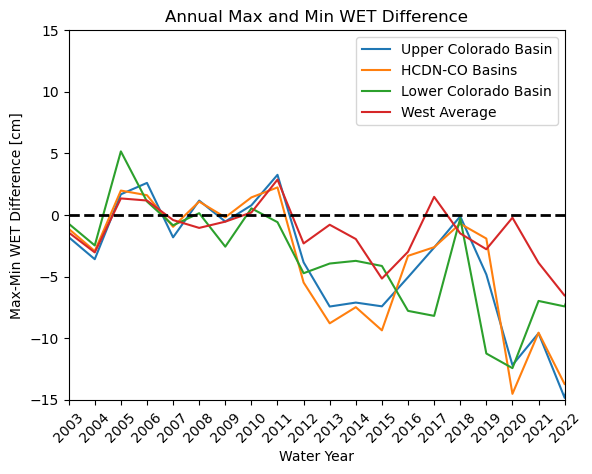

In [56]:

fig, ax = plt.subplots()

(np.abs(grace_corrected_filtered_ds.mean(dim=['x','y']).groupby('WY').max()['lwe_thickness'])-np.abs(grace_corrected_filtered_ds.mean(dim=['x','y']).groupby('WY').min()['lwe_thickness'])).plot(ax=ax, label='Upper Colorado Basin')
(np.abs(grace_corrected_filtered_ds_hcdn.mean(dim=['x','y']).groupby('WY').max()['lwe_thickness'])-np.abs(grace_corrected_filtered_ds_hcdn.mean(dim=['x','y']).groupby('WY').min()['lwe_thickness'])).plot(ax=ax, label='HCDN-CO Basins')
(np.abs(grace_corrected_filtered_ds_lower.mean(dim=['x','y']).groupby('WY').max()['lwe_thickness'])-np.abs(grace_corrected_filtered_ds_lower.mean(dim=['x','y']).groupby('WY').min()['lwe_thickness'])).plot(ax=ax, label='Lower Colorado Basin')
(np.abs(grace_corrected_filtered_ds_west.mean(dim=['x','y']).groupby('WY').max()['lwe_thickness'])-np.abs(grace_corrected_filtered_ds_west.mean(dim=['x','y']).groupby('WY').min()['lwe_thickness'])).plot(ax=ax, label='West Average')
ax.axhline(0,lw=2,color='k',ls='--')
ax.set_xticks(np.arange(2003,2023,1))
ax.set_xticklabels(np.arange(2003,2023,1), rotation=45);
ax.set_ylabel('Max-Min WET Difference [cm]')
ax.set_xlabel('Water Year')
ax.set_title('Annual Max and Min WET Difference')
ax.set_xlim(2003,2022)
ax.set_ylim(-15,15)
ax.legend()